# Машинное обучение, РЭШ

## Практическое задание 4. Классификация. 

### Общая информация
Дата выдачи: 25.11.2020

Мягкий дедлайн: 23:59MSK 03.11.2020 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 05.11.2020

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания загрузите *.ipynb файл на my.nes.
Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 10!

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import  LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, auc
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [10]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). 

In [11]:
C_values = np.linspace(0.01, 10, 10)
searcher_svm = GridSearchCV(LinearSVC(), [{'C':C_values}], scoring = 'roc_auc' )
searcher_svm.fit(X_train, y_train)
print('Best parameter is {:.3f}'.format(searcher_svm.best_params_['C']))

Best parameter is 5.560


На тестовой части посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Постройте ROC и PR кривые, сравните их с ответами случайного классификатора. Заметим, что с помощью `sklearn` можно посчитать обе метрики двумя разными способами - в чем их различия? Сравните результаты. 

ROC-AUC = 0.84785, PR-AUC = 0.82817


[]

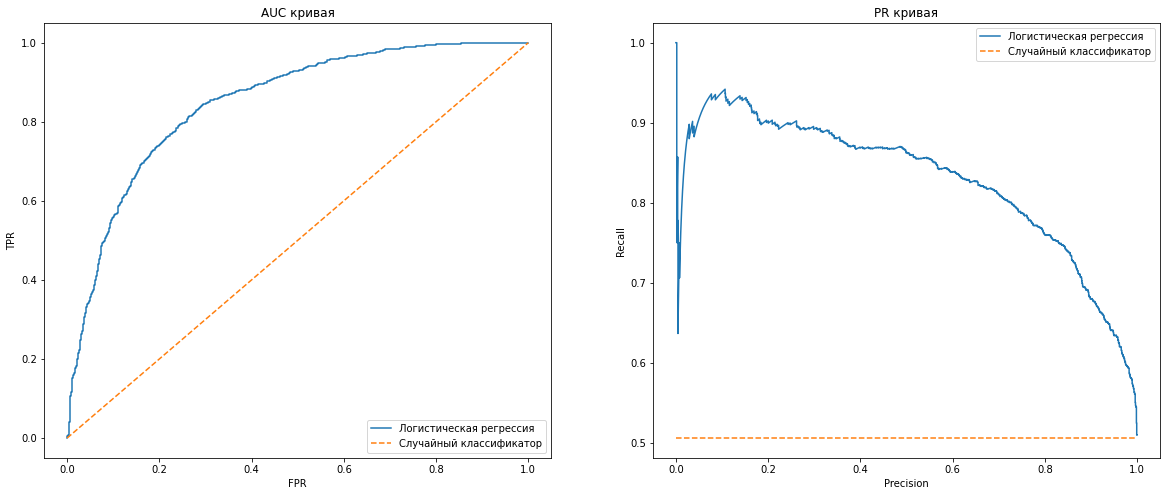

In [12]:
model_svm = LinearSVC(C = searcher_svm.best_params_['C'])
model_svm.fit(X_train, y_train)

sigma = lambda x: 1/(1+np.exp(-x))
y_pred_svm = sigma(model_svm.decision_function(X_test))
# y_test_predict = model_svm.predict_proba(X_test)[:,1]

print(f'ROC-AUC = {roc_auc_score(y_test, y_pred_svm):.5f}, PR-AUC = {average_precision_score(y_test, y_pred_svm):.5f}')

roc = roc_curve(y_test, y_pred_svm)
pr = precision_recall_curve(y_test, y_pred_svm)

fig, ax = plt.subplots(1,2,figsize = (20,8))

# metrics.plot_roc_curve(model_svm, X_test, y_test) 
ax[0].plot(roc[0], roc[1], label = 'Логистическая регрессия')
ax[0].plot([0, 1], [0, 1], linestyle='--', label='Случайный классификатор')
ax[0].set(title = 'AUC кривая',
       xlabel = 'FPR',
       ylabel = 'TPR')
ax[0].legend(loc="lower right")

ax[1].plot(pr[1],pr[0], label = 'Логистическая регрессия')
const_prec = np.mean(y_test)
ax[1].plot([0, 1], [const_prec, const_prec], linestyle='--', label='Случайный классификатор')
ax[1].set(title = 'PR кривая',
       xlabel = 'Precision',
       ylabel = 'Recall')
ax[1].legend(loc="upper right")
plt.plot()

Ну, случайный классификатор мы превзошли! Да и значения метрик неплохие. 

Посмотрим на разные способы вычисления:

In [13]:
print(f'ROC-AUC прямоугольниками = {roc_auc_score(y_test, y_pred_svm)}, ROC-AUC трапециями = {auc(roc[0], roc[1])}')
print(f'PR-AUC прямоугольниками = {average_precision_score(y_test, y_pred_svm)}, PR-AUC трапециями = {auc(pr[1], pr[0])}')

ROC-AUC прямоугольниками = 0.8478466789734325, ROC-AUC трапециями = 0.8478466789734325
PR-AUC прямоугольниками = 0.8281660777884629, PR-AUC трапециями = 0.8279029494709181


Формально разница в способах заключается в том, что в первом случае мы используем "специальный" метод для вычисления метрики, а во втором - строим соответствующую кривую и считаем площадь под ней. По факту же, мы видим разницу для PR потому, что auc считает площаль трапециями, а метод "на прямую" - прямоугольниками. Для ROC же разницы между этими способами нет.  

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [14]:
C_values = np.linspace(0.1, 10, 100)
searcher_lr = GridSearchCV(LogisticRegression(), [{'C':C_values}], scoring = 'roc_auc' )
searcher_lr.fit(X_train, y_train)
print('Best parameter is {:.3f}'.format(searcher_lr.best_params_['C']))

Best parameter is 5.200


ROC-AUC = 0.84788, PR-AUC = 0.82938


[]

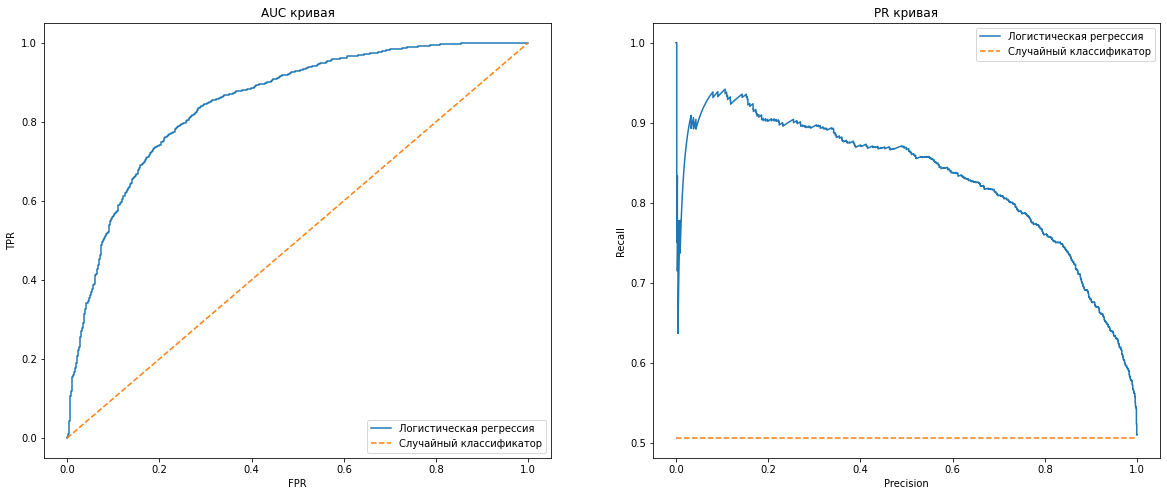

In [15]:
model_lr = LogisticRegression(C=searcher_lr.best_params_['C'])
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict_proba(X_test)[:,1]

print(f'ROC-AUC = {roc_auc_score(y_test, y_pred_lr):.5f}, PR-AUC = {average_precision_score(y_test, y_pred_lr):.5f}')

roc = roc_curve(y_test, y_pred_lr)
pr = precision_recall_curve(y_test, y_pred_lr)

fig, ax = plt.subplots(1,2,figsize = (20,8))

ax[0].plot(roc[0], roc[1], label = 'Логистическая регрессия')
ax[0].plot([0, 1], [0, 1], linestyle='--', label='Случайный классификатор')
ax[0].set(title = 'AUC кривая',
       xlabel = 'FPR',
       ylabel = 'TPR')
ax[0].legend(loc="lower right")

ax[1].plot(pr[1],pr[0], label = 'Логистическая регрессия')
const_prec = np.mean(y_test)
ax[1].plot([0, 1], [const_prec, const_prec], linestyle='--', label='Случайный классификатор')
ax[1].set(title = 'PR кривая',
       xlabel = 'Precision',
       ylabel = 'Recall')
ax[1].legend(loc="upper right")
plt.plot()

In [16]:
print(f'ROC-AUC прямоугольниками = {roc_auc_score(y_test, y_pred_lr)}, ROC-AUC трапециями = {auc(roc[0], roc[1])}')
print(f'PR-AUC прямоугольниками = {average_precision_score(y_test, y_pred_lr)}, PR-AUC трапециями = {auc(pr[1], pr[0])}')

ROC-AUC прямоугольниками = 0.8478760160749534, ROC-AUC трапециями = 0.8478760160749534
PR-AUC прямоугольниками = 0.8293820493443467, PR-AUC трапециями = 0.8291185510482846


Разница между метриками аналогичная описанной выше для SVM. Давайте теперь сравним SVM и LR. Видим, что AUC ROC практически идентичны. AUC PR чуть ниже у SVM, но тоже незначительно.  

Логистическая регрессия приближает в каждой точке пространства объектов правдоподобие положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

In [17]:
n = 1000
X, y = make_classification(
    n_samples=n, n_features=2, n_informative=2, n_redundant=0,
    random_state=42)

model_LR = LogisticRegression(C=searcher_lr.best_params_['C'])
model_LR.fit(X, y)

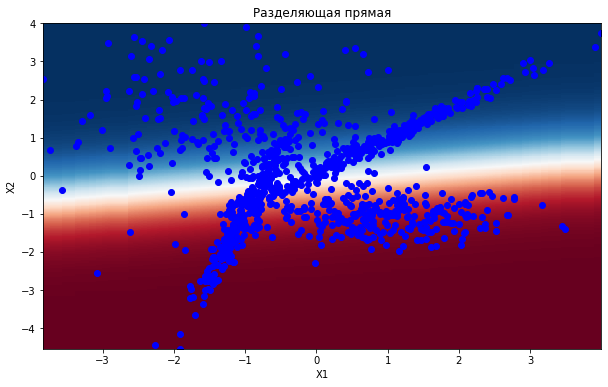

In [40]:
X1 = np.tile(np.sort(X[:,0]), n)
X2 = np.repeat(np.sort(X[:,1]), n) 
y = model_LR.predict_proba(np.column_stack((X1,X2)))[:,1]

fig,ax=plt.subplots(figsize = (10,6))

ax.pcolor(X1.reshape(n,n),  X2.reshape(n,n), y.reshape(n,n), cmap='RdBu')
ax.set(title = 'Разделяющая прямая',
       xlabel = 'X1',
       ylabel = 'X2')
ax.scatter(X[:,0], X[:,1], c='blue')
plt.show()

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [42]:
def plot_calibration_curve(y_test, preds, name):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) 
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) 
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios, label = name + ' классификатор')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Идеальная калибровка')
    plt.title('Калибровка ' + name + ' модели')
    plt.xlabel('Бины')
    plt.ylabel('Вероятности')
    plt.legend(loc="lower right")
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетический датасет аналогично использованному в самом первом задании — он будет выступать в качестве тестовой выборки. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

Не уверен, что правильно понял задание. Мы в самом начале уже сгенерировали датасет и разделили лиго на обучающую и тестовую выборку. Генерировать еще раз на том же сиде - даст такой же датасет. Генерировать на другом сиде - нерелевантную выборку к построенной модели (мы обучались на совсем других данных). Кажется, надо взять уже существующую тестовую выборку из предыдущего пункта и построить на ней. Так и сделаем. 

Посмотрим на ответы моделей (не вероятности):

[]

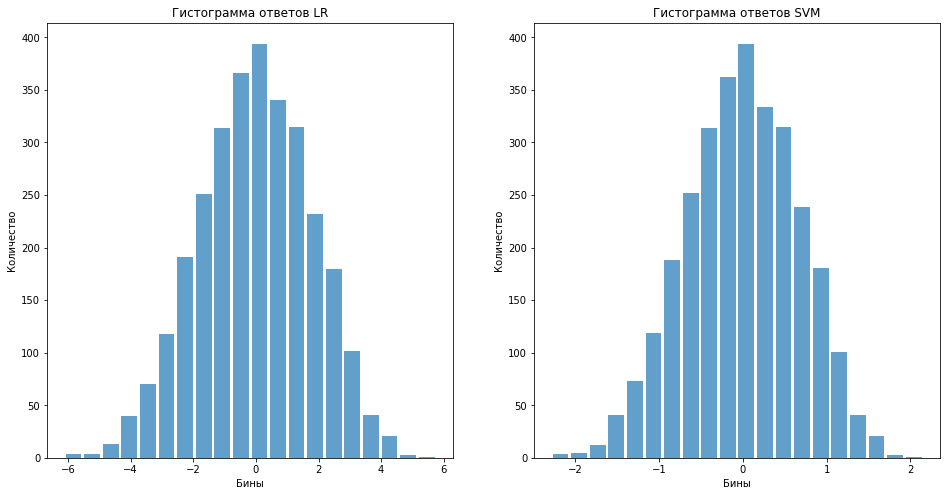

In [43]:
fig,ax = plt.subplots(1,2,figsize = (16,8))

ax[0].hist(model_lr.decision_function(X_test), 20, alpha=0.7, rwidth=0.85)
ax[0].set(title = 'Гистограмма ответов LR',
       xlabel = 'Бины',
       ylabel = 'Количество')
ax[1].hist(model_svm.decision_function(X_test),20, alpha=0.7, rwidth=0.85)
ax[1].set(title = 'Гистограмма ответов SVM',
       xlabel = 'Бины',
       ylabel = 'Количество')

plt.plot()

Видно, что они очень похожи. Вот только ответы SVM значительно ближе к 0 (см. ось X). Построем для них калибровочные кривые:

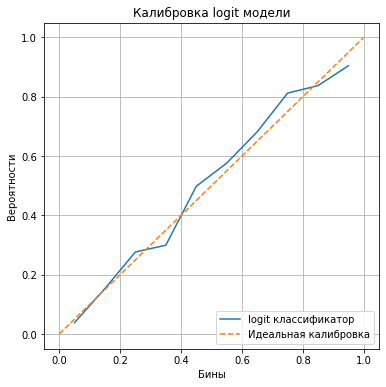

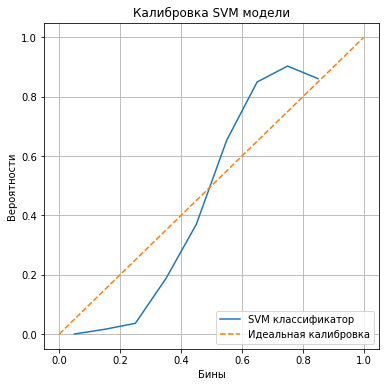

In [44]:
plot_calibration_curve(y_test, y_pred_lr, 'logit')
plot_calibration_curve(y_test, y_pred_svm, 'SVM')

Видно, что SVM недопредсказывает вероятность 0 и перепредсказывает вероятность 1. Т.е. среди тех, кому он дает вероятость 0.3, положительных классов слишком мало, а среди 0.7 - слишком много. При этом в середине (0.5) баланс соблюдается. Это связано с особенностью SVM, он хорошо разделяет объекты, но (вспомним L(M) в сравнении с логистической регрессией) не очень хорошо ранжирует их по отступу. 

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

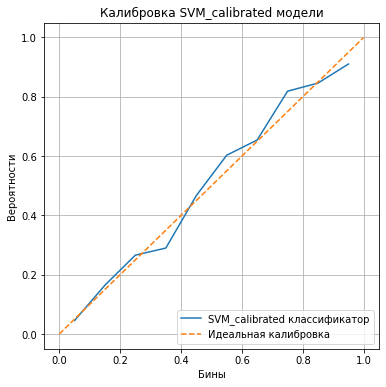

In [45]:
from sklearn.calibration import CalibratedClassifierCV

model_svm = LinearSVC(C = searcher_svm.best_params_['C'])
cal = CalibratedClassifierCV(base_estimator = model_svm, method = 'sigmoid')
model_svm_cal = cal.fit(X_train, y_train)

plot_calibration_curve(y_test, model_svm_cal.predict_proba(X_test)[:,1], 'SVM_calibrated')

Другое дело! Стало лучше и очень похоже на логистическую. 

# Часть 1. Работа с переменными.

In [46]:
!pip install category_encoders
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

     |████████████████████████████████| 81kB 5.0MB/s 


В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [47]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2020-12-03 19:11:10--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Saving to: ‘bank-additional.zip’

bank-additional.zip 100%[===================>] 434.15K   575KB/s    in 0.8s    

2020-12-03 19:11:12 (575 KB/s) - ‘bank-additional.zip’ saved [444572/444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/.

__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



Удалим duration, выдержка из документации: "Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model"

In [48]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['y','duration']),
                                                    (df['y']=='yes').astype('int'), 
                                                    random_state = 777, stratify = df['y'])

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?



In [49]:
df['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

__Ваш ответ__: как мы видим, классы не сбалансированы. Поэтому стоит использовать PR, а не AUC.

In [50]:
categorical = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
numeric_features = ['age', 'campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

column_transformer_OE = ColumnTransformer([
    ('ohe', OrdinalEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

OE_pipeline = Pipeline([
    ('transformer', column_transformer_OE),
    ('regression', LogisticRegression())
])

In [51]:
%%time
model_lr = OE_pipeline.fit(X_train, y_train)

CPU times: user 850 ms, sys: 393 ms, total: 1.24 s
Wall time: 689 ms


In [52]:
print(f'PR-AUC = {average_precision_score(y_test, model_lr.predict_proba(X_test)[:,1]):.5f}')

PR-AUC = 0.44229


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [53]:
column_transformer_OHE = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

OHE_pipeline = Pipeline([
    ('transformer', column_transformer_OHE),
    ('regression', LogisticRegression())
])

In [54]:
%%time
model_lr = OHE_pipeline.fit(X_train, y_train)

CPU times: user 1.37 s, sys: 395 ms, total: 1.76 s
Wall time: 963 ms


In [55]:
print(f'PR-AUC = {average_precision_score(y_test, model_lr.predict_proba(X_test)[:,1]):.5f}')

PR-AUC = 0.44951


Стало немного лучше)

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Можете воспользоваться [библиотекой](https://contrib.scikit-learn.org/category_encoders/targetencoder.html) с четвертого семинара или написать класс сами. Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


In [56]:
column_transformer_MTE = ColumnTransformer([
    ('ohe', TargetEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

MTE_pipeline = Pipeline([
    ('transformer', column_transformer_MTE),
    ('regression', LogisticRegression())
])

In [57]:
%%time
model_lr = MTE_pipeline.fit(X_train, y_train)

CPU times: user 1.07 s, sys: 388 ms, total: 1.46 s
Wall time: 997 ms


In [ ]:
print(f'PR-AUC = {average_precision_score(y_test, model_lr.predict_proba(X_test)[:,1]):.5f}')

PR-AUC = 0.44257


Заметим, что OE в кодировке и обучении занимает значительно меньше времени, чем OHE и MTE: он самый простой, дает меньше признаков, чем OHE (влияет на скорость обучения) и кодирует простым алгоритмом (влияет на скорость кодирования). 

В то же время видно, что OE дает такое же качество как MTE, а OHE превосходит их обоих. OHE>OE - довольно предсказуемо, а вот остальное - странно. 

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания. Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


Ответ на вопрос обсуждаля на лекции. При MTE без сглаживания мы просто переписываем ответ в редкую категорию, это не очень честно. Как только есть подозрение на редкие классы/несбалансированность стоит использовать сглаживание. 

__Задание 6 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [58]:
# !pip install category_encoders
from category_encoders import TargetEncoder
column_transformer_MTE_sm = ColumnTransformer([
    ('ohe', TargetEncoder(smoothing=0.1), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

MTE_sm_pipeline = Pipeline([
    ('transformer', column_transformer_MTE_sm),
    ('regression', LogisticRegression())
])

In [59]:
%%time
model_lr = MTE_sm_pipeline.fit(X_train, y_train)

CPU times: user 1.08 s, sys: 343 ms, total: 1.43 s
Wall time: 915 ms


In [60]:
print(f'PR-AUC = {average_precision_score(y_test, model_lr.predict_proba(X_test)[:,1]):.5f}')

PR-AUC = 0.44249


Получили что-то на уровне MTE, чуть быстрее (странно), чуть лучше (логично, чуть меньше переобучились). Они очень похожи. 

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ MTE строится совсем по другому принципу по сравнению с OHE. OHE совсем не умеет во взаимосвязь между категориями и сложные связи между признаками - для MTE это не проблема. MTE к тому же создает меньше переменных, что влияет ускоряет обучение. Однако MTE требует больше времени на создание переменных (более сложный алгоритм). В то же время, MTE искусственен и может страдать от эндогенности: нужны костыли (типа априорности или шума), чтобы помешать ему переобучиться.  Вдобавок к этому MTE может легче переобучиться - запомнить структуру обучающего сэмпла (вспомним пример с чартами).      

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про банковский телефонный маркетинг.

In [61]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

Будем пока делать без масштабирования. 

In [62]:
column_transformer_OHE = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
])

OHE_pipeline = Pipeline([
    ('transformer', column_transformer_OHE),
    ('regression', LogisticRegression())
])

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [63]:
model_lr = OHE_pipeline.fit(X_train, y_train)
print(f'PR-AUC = {average_precision_score(y_test, model_lr.predict_proba(X_test)[:,1]):.5f}')

PR-AUC = 0.40900


In [64]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer_OHE.transform(X_train).shape)

Size before OneHot: (32950, 19)
Size after OneHot: (32950, 53)


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 7 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [65]:
%%time
X_train_OHE = column_transformer_OHE.transform(X_train)
X_test_OHE = column_transformer_OHE.transform(X_test)
model_l = LinearRegression()
model_l.fit(X_train_OHE, y_train)
selected_features = np.absolute(model_l.coef_).argsort()[-40:][::-1] 

CPU times: user 246 ms, sys: 76.9 ms, total: 323 ms
Wall time: 230 ms


In [66]:
X_train_emb = X_train_OHE[:, selected_features]
X_test_emb = X_test_OHE[:, selected_features ]

model_lr = LogisticRegression()
model_lr.fit(X_train_emb, y_train)
print(f'PR-AUC = {average_precision_score(y_test, model_lr.predict_proba(X_test_emb)[:,1]):.5f}')

PR-AUC = 0.40791


А качесто то изменилось не сильно! Хотя мы выкинули почти четверь признаков, они были неоч и мы почти не потеряли в качестве. 

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

На всех признаках:

In [67]:
column_transformer_OHE = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

OHE_pipeline = Pipeline([
    ('transformer', column_transformer_OHE),
    ('regression', LogisticRegression())
])

model_lr = OHE_pipeline.fit(X_train, y_train)
print(f'PR-AUC = {average_precision_score(y_test, model_lr.predict_proba(X_test)[:,1]):.5f}')

PR-AUC = 0.44775


С отбором:

In [68]:
X_train_OHE = column_transformer_OHE.transform(X_train)
X_test_OHE = column_transformer_OHE.transform(X_test)
model_l = LinearRegression()
model_l.fit(X_train_OHE, y_train)
X_train_emb = X_train_OHE[:, np.absolute(model_l.coef_).argsort()[-40:][::-1] ]
X_test_emb = X_test_OHE[:, np.absolute(model_l.coef_).argsort()[-40:][::-1] ]

model_lr = LogisticRegression()
model_lr.fit(X_train_emb, y_train)
print(f'PR-AUC = {average_precision_score(y_test, model_lr.predict_proba(X_test_emb)[:,1]):.5f}')

PR-AUC = 0.24868


Видно, что уже все не так радужно, как без масштаирования. Странно, аргумент выше про необходимость масштабирования валидный. 


### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [70]:
%%time
mu_p=np.mean(X_train_OHE[y_train,:], axis=0)
mu_n=np.mean(X_train_OHE[~y_train,:], axis=0)

var_p = np.std(X_train_OHE[y_train,:], axis=0)**2
var_n = np.std(X_train_OHE[~y_train,:], axis=0)**2

n_p = y_train[y_train].shape[0]
n_n = y_train[~y_train].shape[0]

t_stat = np.abs(mu_p - mu_n) / ((var_p * n_p + var_n * n_n)/(n_p + n_n))**0.5

selected_features = t_stat.argsort()[-40:][::-1] 

CPU times: user 34.6 ms, sys: 2.71 ms, total: 37.4 ms
Wall time: 39.2 ms


In [71]:
X_train_emb = X_train_OHE[:, selected_features]
X_test_emb = X_test_OHE[:, selected_features ]

model_lr = LogisticRegression()
model_lr.fit(X_train_emb, y_train)
print(f'PR-AUC = {average_precision_score(y_test, model_lr.predict_proba(X_test_emb)[:,1]):.5f}')

PR-AUC = 0.45171


### Методы-обёртки

__Задание 9 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

Воспользуемся сторонней библиотекой, хоть она и излишне долгая:

In [73]:
%%time
# !pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

model_lr = LogisticRegression()

sfs1 = sfs(model_lr,
           k_features=40,
           forward=False,
           floating=False,
           scoring='roc_auc',
           cv=5)

sfs1 = sfs1.fit(X_train_OHE, y_train)

CPU times: user 1h 26min 51s, sys: 33min 39s, total: 2h 31s
Wall time: 1h 1min 15s


In [74]:
X_train_emb = X_train_OHE[:, sfs1.k_feature_idx_]
X_test_emb = X_test_OHE[:, sfs1.k_feature_idx_ ]

model_lr = LogisticRegression()
model_lr.fit(X_train_emb, y_train)
print(f'PR-AUC = {average_precision_score(y_test, model_lr.predict_proba(X_test_emb)[:,1]):.5f}')

PR-AUC = 0.44522


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 

* Стоит отметить, что встроенные методы и обертки очень похожи. В общем случае у нас есть n признаков и мы хотим отобрать из них подмножество k, такое что качество модели на k признаках - наилучшее. Мы можем перебрать все $C_n^k$ вариантов и найти оптимум, но это долговато) Поэтому в качестве прокси и используется такие упрощения. 
* Встроенные методы хороши своей простотой и интерпретируемостью. Однако они не учитывают динамические свойства построения регрессии: оставить 40 лучших исходя из одной регресии - не самое точное приближении лучшего варианта. 
* Сильно лучше в этом плане методы-обертки - пусть алгоритм и жадный, но мы перебираем довольно много правдоподобных вариантов. Как мне кажется, это хороший баланс (в средних условиях: когда крупицы качества не супер важны и стоимость ресурсов на обучение не зашкаливает) между временем и оптимальностью. 
* Методы фильтрации (кроме описанного выше еще WOE очень часто используется) тоже хороши в простоте и интерпретируемости, но они не учитывают взаимосвязь между переменными. Мы можем выбрать две лучших по WOE фичи, а окажется, что они отражают одно и то же и выгоднее вместо top2 взять что-то похуже. 

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 10 (1.5 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания (`predict(...)`) для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [75]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')
X = df.drop(columns=['y','duration'])
y = (df['y']=='yes').astype('int')


column_transformer_OHE = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

OHE_pipeline = Pipeline([
    ('transformer', column_transformer_OHE),
    ('regression', LogisticRegression())
])

revenues, costs = [], []
kf = KFold(n_splits=5, random_state=500, shuffle=True)
for train_index, test_index in kf.split(X):
  X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
  y_train, y_test = y[train_index], y[test_index]
  
  model_lr = OHE_pipeline.fit(X_train, y_train)
  y_test_pred = model_lr.predict(X_test)
  revenues.append(10*np.sum(y_test*y_test_pred))
  costs.append(np.sum(y_test_pred))

In [76]:
print('Our revenues', revenues)
print('Our costs', costs)
print('An average revenue: {:.0f}, standard deviation: {:.2f}'.format(np.mean(revenues), np.std(revenues)))
print('An average profit: ', np.mean(np.asarray(revenues) - np.asarray(costs)))

Our revenues [2240, 2110, 2080, 2240, 1970]
Our costs [309, 330, 328, 330, 321]
An average revenue: 2128, standard deviation: 102.65
An average profit:  1804.4


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [77]:
revenues_rand, costs_rand = [], []
kf = KFold(n_splits=5, random_state=500, shuffle=True)
for train_index, test_index in kf.split(X):
  X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
  y_train, y_test = y[train_index], y[test_index]
  
  model_lr = OHE_pipeline.fit(X_train, y_train)
  y_test_pred = model_lr.predict(X_test)
  revenues_rand.append(np.sum(np.random.randint(20, size=y_test.shape)*y_test*y_test_pred))
  costs_rand.append(np.sum(y_test_pred))

print('Our revenues', revenues_rand)
print('Our costs', costs_rand)
print('An average revenue: {:.0f}, standard deviation: {:.2f}'.format(np.mean(revenues_rand), np.std(revenues_rand)))
print('An average profit: ', np.mean(np.asarray(revenues_rand) - np.asarray(costs_rand)))

Our revenues [1979, 2041, 2151, 2009, 1883]
Our costs [309, 330, 328, 330, 321]
An average revenue: 2013, standard deviation: 87.06
An average profit:  1689.0


Видно, что выручка и косты остались в среднем теми же - средняя прибыль отличается меньше, чем на процент! При этом стандартное отклонение выросло. Все эффекты логичны и ожидаемы: мы лишь добавили вариации в доходы, но из-за закона больших чисел..

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [78]:
C = np.linspace(0.01, 10, 10)

profits,errors = [],[]
for c in C:
  revenues_rand, costs_rand = [], []
  kf = KFold(n_splits=5, random_state=500, shuffle=True)
  for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    
    OHE_pipeline = Pipeline([
        ('transformer', column_transformer_OHE),
        ('regression', LogisticRegression(C=c))
    ])

    model_lr = OHE_pipeline.fit(X_train, y_train)
    y_test_pred = model_lr.predict(X_test)
    revenues_rand.append(np.sum(np.random.randint(20, size=y_test.shape)*y_test*y_test_pred))
    costs_rand.append(np.sum(y_test_pred))
  profits.append(np.mean(np.asarray(revenues_rand) - np.asarray(costs_rand)))
  errors.append(np.std(np.asarray(revenues_rand) - np.asarray(costs_rand)))

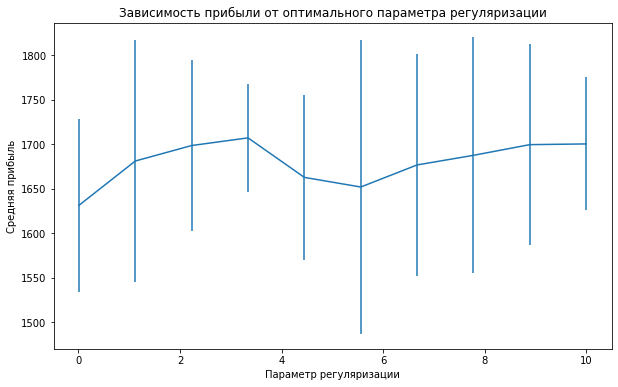

In [79]:
fig, ax = plt.subplots(figsize = (10,6))

ax.errorbar(C,profits,errors)
ax.set(title = 'Зависимость прибыли от оптимального параметра регуляризации',
       xlabel = 'Параметр регуляризации',
       ylabel = 'Средняя прибыль')
plt.show()
# fig.savefig("profit_3.pdf")

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

Я запустил алгоритм несколько раз и закономерности в лучшей прибыли не наблюдается (в разных прогонах разные оптимальные параметры). Из этого можно сделать вывод, что такой способ подбора гиперпараметра не имеет смысла - мы переобучимся на нерелевантной информации (отсутствует external validity). К тому же мы видим, что стандартные ошибки довольно велики - на их фоне различия между разными значениями параметра отличаются незначительно.

__Задание 11 (1.5 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ precision = сколько из найденных действительно положительные, recall = сколько из положительных нашли. Заметим, что стоимость реакции для нас относительно мала - 1 (мы не учитываем негативные последствия беспокойства клиента, только стоимость звонка) по сравнению с прибылью от удачного звонка (const=10, или матож=10). Поэтому при прочих равных нам выгодно среагировать для лишнего клиента, чем нет. Поэтому высокий recall для нас важнее высокого precision. Вот если бы это был бизнес-класс и стоимость промаха была бы сильно выше...

Ниже мы увидим подтверждение этой гипотезы.



Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности (`predict_proba(...)`) положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
OHE_pipeline = Pipeline([
        ('transformer', column_transformer_OHE),
        ('regression', LogisticRegression())
    ])

C = np.linspace(0, 1, 101)

profits,errors = [],[]
for c in C:
  revenues_rand, costs_rand = [], []
  kf = KFold(n_splits=5, random_state=500, shuffle=True)
  for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    
    model_lr = OHE_pipeline.fit(X_train, y_train)
    y_test_pred = (model_lr.predict_proba(X_test)[:,1]>c)*1
    revenues_rand.append(np.sum(np.random.randint(20, size=y_test.shape)*y_test*y_test_pred))
    costs_rand.append(np.sum(y_test_pred))
  profits.append(np.mean(np.asarray(revenues_rand) - np.asarray(costs_rand)))
  errors.append(np.std(np.asarray(revenues_rand) - np.asarray(costs_rand)))

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

ax.errorbar(C,profits,errors)
ax.set(title = 'Зависимость прибыли от оптимального параметра разбиения',
       xlabel = 'Параметр разбиения',
       ylabel = 'Средняя прибыль')
plt.show()
fig.savefig("barrier_2.pdf")

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

Несколько построений дают нам очень похожие паттерны. Каждый раз оптимальный порог оказывается в районе [0.1,0.2], пусть 0.15 в среднем. Это говорит о том, что нам выгодно звонить, как только вероятность успеха хотябы 15\%! Т.е. действительно, мы готовы обзванивать с запасом, закладывая долю неудач, ради того, чтобы найти успешные кейсы и максимизировать прибыль. Иными словами, recall важнее precision. 

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

Возьмем в качестве порога 0.15. 

In [ ]:
from sklearn.metrics import precision_score,recall_score
С = 0.15
prec, rec = [], []
kf = KFold(n_splits=5, random_state=500, shuffle=True)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    
    model_lr = OHE_pipeline.fit(X_train, y_train)
    y_test_pred = (model_lr.predict_proba(X_test)[:,1]>c)*1

    prec.append(precision_score(y_test, y_test_pred))
    rec.append(recall_score(y_test, y_test_pred)) 
    
print('Our precisons', prec)
print('Standard deviation: {:.2f}'.format(np.std(prec)))
print('Our recalls', rec)
print('Standard deviation: {:.2f}'.format(np.std(rec)))

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ чай :(